Cell 1: Imports & Setup

In [1]:

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_fscore_support

# Path Configuration
DATASET_ROOT = r"G:\Thesis-Fall-25-26--G-606\data"
IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

# Hyperparameters (ANN)
IMG_SIZE = (64, 64) 
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20
SEED = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")


Using Device: cuda


Cell 2: Dataset Class

In [2]:

class GlaucomaDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_name = self.annotations.iloc[index, 0]
        label_str = self.annotations.iloc[index, 2]
        img_path = os.path.join(self.root_dir, img_name)
        
        image = cv2.imread(img_path)
        if image is None:
            image = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = 1 if label_str == 'GON+' else 0
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)


Cell 3: Simple ANN Architecture

In [3]:

class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.flatten = nn.Flatten()
        self.input_dim = IMG_SIZE[0] * IMG_SIZE[1] * 3
        
        # Shallow Network (2 Hidden Layers)
        self.fc1 = nn.Linear(self.input_dim, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Cell 4: Training Engine

In [4]:

def train_model(model, train_loader, test_loader, epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    
    print(f"\n--- Training {model_name} ---")
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0; correct = 0; total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_acc = 100 * correct / total
        epoch_train_loss = running_loss / len(train_loader)
        history['train_acc'].append(epoch_train_acc)
        history['train_loss'].append(epoch_train_loss)
        
        # Validation
        model.eval()
        val_correct = 0; val_total = 0; val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_acc = 100 * val_correct / val_total
        epoch_val_loss = val_loss / len(test_loader)
        history['val_acc'].append(epoch_val_acc)
        history['val_loss'].append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {epoch_train_acc:.1f}% | Val Acc: {epoch_val_acc:.1f}%")
            
    return history


Cell 5: Stage 1 - Raw Data

In [5]:

print("--- STAGE 1: ANN Baseline (Raw Data) ---")

transform_basic = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_basic)
indices = list(range(len(dataset)))
split = int(np.floor(0.2 * len(dataset)))
np.random.seed(SEED); np.random.shuffle(indices)

train_sampler = SubsetRandomSampler(indices[split:])
test_sampler = SubsetRandomSampler(indices[:split])
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

model_ann = SimpleANN()
history_raw = train_model(model_ann, train_loader, test_loader, EPOCHS, "Simple ANN Baseline")


--- STAGE 1: ANN Baseline (Raw Data) ---

--- Training Simple ANN Baseline ---
Epoch 1/20 | Train Acc: 65.1% | Val Acc: 81.9%
Epoch 2/20 | Train Acc: 72.9% | Val Acc: 87.9%
Epoch 3/20 | Train Acc: 73.7% | Val Acc: 72.5%
Epoch 4/20 | Train Acc: 74.7% | Val Acc: 83.2%
Epoch 5/20 | Train Acc: 82.4% | Val Acc: 83.9%
Epoch 6/20 | Train Acc: 80.4% | Val Acc: 88.6%
Epoch 7/20 | Train Acc: 84.3% | Val Acc: 89.9%
Epoch 8/20 | Train Acc: 88.8% | Val Acc: 91.9%
Epoch 9/20 | Train Acc: 89.8% | Val Acc: 87.2%
Epoch 10/20 | Train Acc: 89.0% | Val Acc: 85.2%
Epoch 11/20 | Train Acc: 82.3% | Val Acc: 82.6%
Epoch 12/20 | Train Acc: 87.8% | Val Acc: 88.6%
Epoch 13/20 | Train Acc: 90.0% | Val Acc: 93.3%
Epoch 14/20 | Train Acc: 89.0% | Val Acc: 89.3%
Epoch 15/20 | Train Acc: 90.1% | Val Acc: 86.6%
Epoch 16/20 | Train Acc: 89.0% | Val Acc: 94.6%
Epoch 17/20 | Train Acc: 89.1% | Val Acc: 93.3%
Epoch 18/20 | Train Acc: 81.1% | Val Acc: 82.6%
Epoch 19/20 | Train Acc: 86.6% | Val Acc: 82.6%
Epoch 20/20 | Trai

CELL 6: STAGE 2 - AUGMENTED DATA 

In [6]:


print("\n--- STAGE 2: ANN Augmented (Improved) ---")

transform_aug = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset_aug = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)
train_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader_aug = DataLoader(dataset_aug, batch_size=BATCH_SIZE, sampler=test_sampler)

model_ann_aug = SimpleANN()
history_aug = train_model(model_ann_aug, train_loader_aug, test_loader_aug, EPOCHS, "Augmented ANN")



--- STAGE 2: ANN Augmented (Improved) ---

--- Training Augmented ANN ---
Epoch 1/20 | Train Acc: 67.7% | Val Acc: 75.8%
Epoch 2/20 | Train Acc: 75.1% | Val Acc: 79.9%
Epoch 3/20 | Train Acc: 80.8% | Val Acc: 85.2%
Epoch 4/20 | Train Acc: 81.8% | Val Acc: 85.9%
Epoch 5/20 | Train Acc: 82.4% | Val Acc: 81.2%
Epoch 6/20 | Train Acc: 82.1% | Val Acc: 80.5%
Epoch 7/20 | Train Acc: 82.6% | Val Acc: 81.2%
Epoch 8/20 | Train Acc: 76.4% | Val Acc: 81.2%
Epoch 9/20 | Train Acc: 82.1% | Val Acc: 89.3%
Epoch 10/20 | Train Acc: 85.6% | Val Acc: 83.2%
Epoch 11/20 | Train Acc: 86.8% | Val Acc: 91.9%
Epoch 12/20 | Train Acc: 86.8% | Val Acc: 89.3%
Epoch 13/20 | Train Acc: 84.8% | Val Acc: 84.6%
Epoch 14/20 | Train Acc: 83.9% | Val Acc: 85.2%
Epoch 15/20 | Train Acc: 85.6% | Val Acc: 93.3%
Epoch 16/20 | Train Acc: 90.1% | Val Acc: 91.3%
Epoch 17/20 | Train Acc: 89.1% | Val Acc: 93.3%
Epoch 18/20 | Train Acc: 85.8% | Val Acc: 86.6%
Epoch 19/20 | Train Acc: 81.9% | Val Acc: 89.9%
Epoch 20/20 | Train Ac

CELL 7: STAGE 3 - CROSS VALIDATION (5-FOLD)

In [7]:

print("\n--- STAGE 3: 5-Fold Cross Validation ---")
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = []
dataset_cv = GlaucomaDataset(LABELS_FILE, IMAGES_DIR, transform=transform_aug)

for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset_cv)):
    print(f"Fold {fold+1}/5...")
    train_sub = SubsetRandomSampler(train_ids)
    val_sub = SubsetRandomSampler(val_ids)
    trainloader_cv = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=train_sub)
    valloader_cv = DataLoader(dataset_cv, batch_size=BATCH_SIZE, sampler=val_sub)
    
    model_cv = SimpleANN()
    model_cv.to(device)
    optimizer = optim.Adam(model_cv.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(10): # Short train for CV
        model_cv.train()
        for img, lab in trainloader_cv:
            img, lab = img.to(device), lab.to(device)
            optimizer.zero_grad()
            outputs = model_cv(img)
            loss = criterion(outputs, lab)
            loss.backward()
            optimizer.step()
            
    model_cv.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for img, lab in valloader_cv:
            img, lab = img.to(device), lab.to(device)
            outputs = model_cv(img)
            _, predicted = torch.max(outputs.data, 1)
            total += lab.size(0)
            correct += (predicted == lab).sum().item()
    acc = 100 * correct / total
    cv_scores.append(acc)
    print(f"   Accuracy: {acc:.2f}%")
print(f"Avg CV Accuracy: {np.mean(cv_scores):.2f}%")



--- STAGE 3: 5-Fold Cross Validation ---
Fold 1/5...
   Accuracy: 89.33%
Fold 2/5...
   Accuracy: 91.33%
Fold 3/5...
   Accuracy: 86.58%
Fold 4/5...
   Accuracy: 80.54%
Fold 5/5...
   Accuracy: 83.89%
Avg CV Accuracy: 86.33%


CELL 8: FULL REPORT & VISUALIZATION

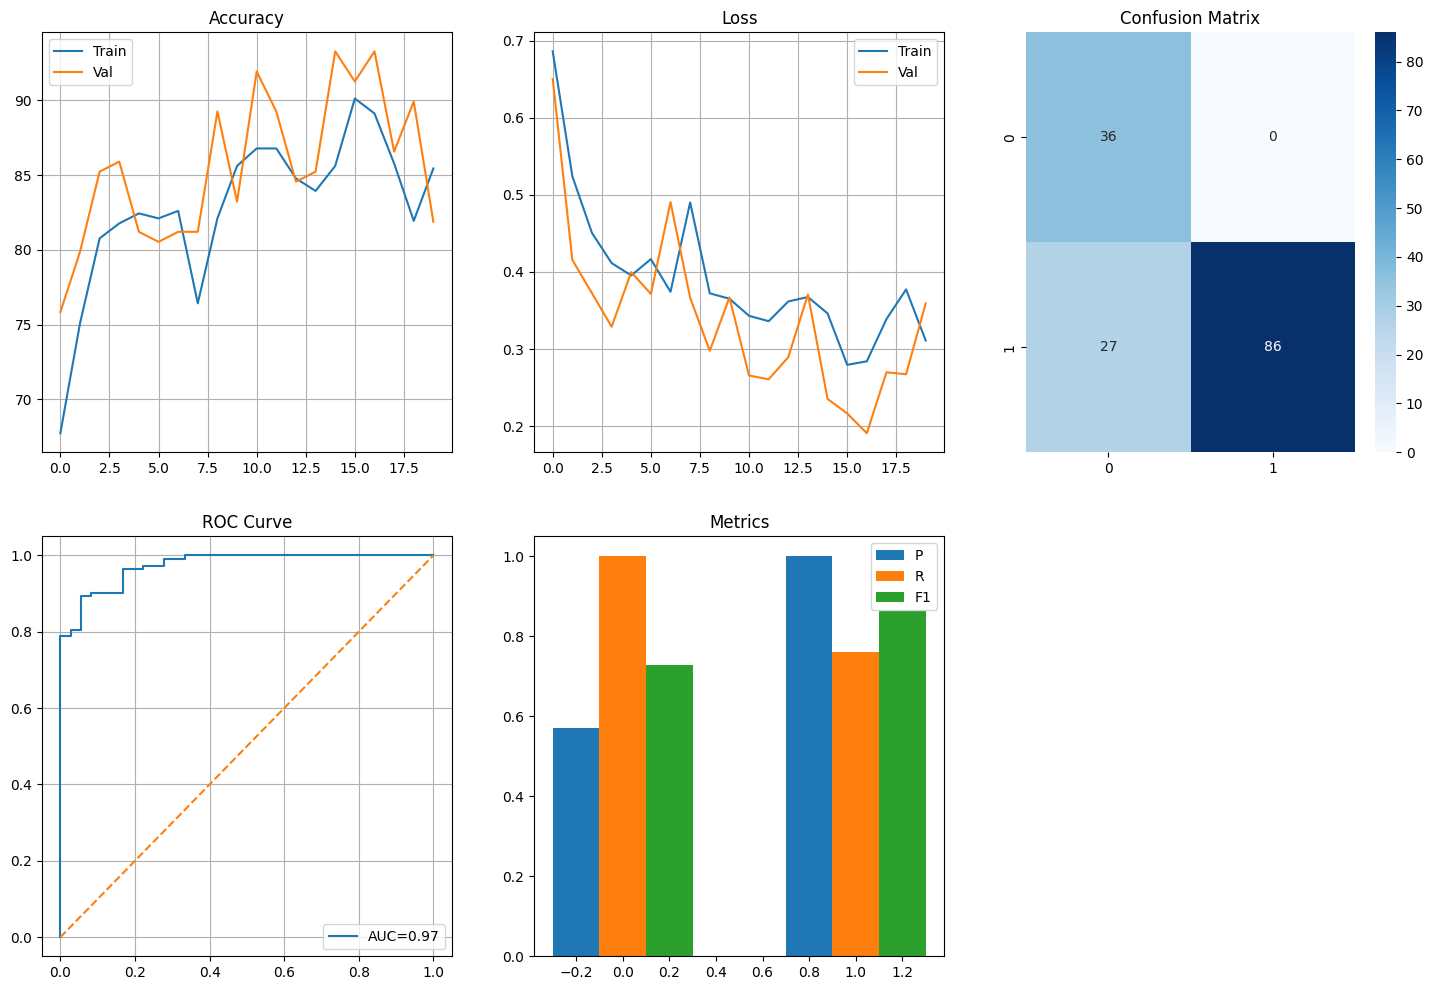


--- Predictions: GON+ vs Healthy ---


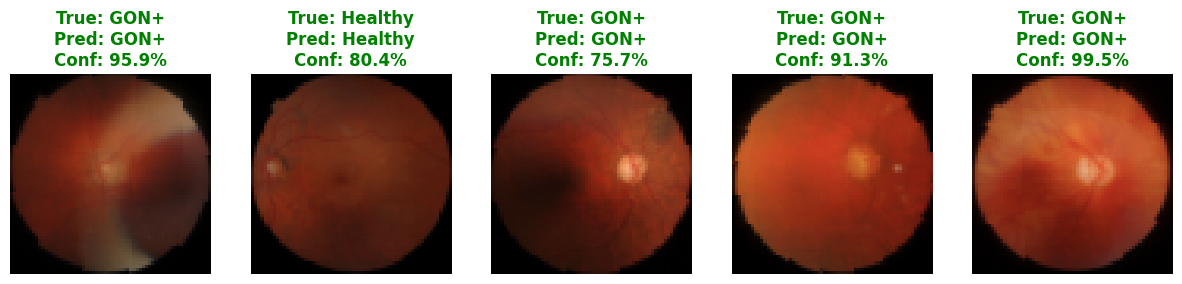

In [8]:

def show_full_report(history, model, loader, device):
    plt.figure(figsize=(18, 12))
    
    # Graphs
    plt.subplot(2, 3, 1); plt.plot(history['train_acc'], label='Train'); plt.plot(history['val_acc'], label='Val'); plt.title('Accuracy'); plt.legend(); plt.grid()
    plt.subplot(2, 3, 2); plt.plot(history['train_loss'], label='Train'); plt.plot(history['val_loss'], label='Val'); plt.title('Loss'); plt.legend(); plt.grid()
    
    # Metrics
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy()); y_pred.extend(predicted.cpu().numpy()); y_probs.extend(probs[:, 1].cpu().numpy())

    plt.subplot(2, 3, 3); sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues'); plt.title('Confusion Matrix')
    plt.subplot(2, 3, 4); fpr, tpr, _ = roc_curve(y_true, y_probs); plt.plot(fpr, tpr, label=f'AUC={auc(fpr, tpr):.2f}'); plt.plot([0,1],[0,1],'--'); plt.title('ROC Curve'); plt.legend(); plt.grid()
    plt.subplot(2, 3, 5); p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average=None); x=np.arange(2); plt.bar(x-0.2, p, 0.2, label='P'); plt.bar(x, r, 0.2, label='R'); plt.bar(x+0.2, f, 0.2, label='F1'); plt.legend(); plt.title('Metrics')
    plt.show()

    # Predictions
    print("\n--- Predictions: GON+ vs Healthy ---")
    plt.figure(figsize=(15, 6))
    images, labels = next(iter(loader))
    images = images.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        confs, preds = torch.max(probs, 1)
        
    for i in range(min(5, len(images))):
        ax = plt.subplot(1, 5, i+1)
        img = images[i].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
        plt.imshow(np.clip(img, 0, 1))
        col = 'green' if preds[i]==labels[i] else 'red'
        true_txt = "GON+" if labels[i]==1 else "Healthy"
        pred_txt = "GON+" if preds[i]==1 else "Healthy"
        plt.title(f"True: {true_txt}\nPred: {pred_txt}\nConf: {confs[i]*100:.1f}%", color=col, fontweight='bold'); plt.axis('off')
    plt.show()

show_full_report(history_aug, model_ann_aug, test_loader_aug, device)


CELL 9: SAVE MODEL 

In [9]:

save_path = os.path.join(DATASET_ROOT, 'ann_best_model.pth')
torch.save(model_ann_aug.state_dict(), save_path)
print(f"ANN Model Saved: {save_path}")

ANN Model Saved: G:\Thesis-Fall-25-26--G-606\data\ann_best_model.pth
